# Import data, python packages, and define customized functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Carol_Copy/Dissertation/dDSP

/content/drive/MyDrive/Carol_Copy/Dissertation/dDSP


In [ ]:
import numpy as np
import pandas as pd
# import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from scipy.stats import skew

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

def bi_pr_test(r_c,N):
  df = N-2
  t_value = r_c * np.sqrt(df) / np.sqrt(1-r_c**2)
  p_value = stats.t.sf(abs(t_value), df)*2  # two-sided pvalue = Prob(abs(t)>tt)
  z_u = np.log((1+r_c)/(1-r_c))/2 + 1.96*np.sqrt(1/(N-3))
  z_l = np.log((1+r_c)/(1-r_c))/2 - 1.96*np.sqrt(1/(N-3))
  r_u = (np.exp(2*z_u)-1)/(np.exp(2*z_u)+1)
  r_l = (np.exp(2*z_l)-1)/(np.exp(2*z_l)+1)
  print('t-statistic = %5.3f pvalue = %6.4f df = %2.0f' % (t_value,p_value,df))
  print('95CI = [%4.2f, %4.2f]' % (r_l,r_u))

def CI_conhen(var,mu):
  print("95% Confidence Interval: {}".format(stats.t.interval(0.95, var.size - 1, var.mean(), stats.sem(var))))
  cohen_d = ( var.mean() - mu )/var.std()
  print("cohen_d {}".format(round(cohen_d,2)))

In [ ]:
strategy = pd.read_csv('strategy.csv')
strategy['ID'] = strategy.TrialID.apply(lambda x: int(x.split('_')[1]))

In [ ]:
wftrajc = pd.read_csv("ProcessedData/analyzed_trajectory.csv")
trial_info = pd.read_csv("desktop_shortcut_trial_info.csv")
wf = wftrajc.merge(strategy[['Subject','ID','human_coding']]\
                   , how = 'left', left_on = ['Subject','TrialID'], right_on = ['Subject','ID'])\
            .merge(trial_info[['TrialID','short_dis','learn_dis']]\
                   , how = 'left', on = 'TrialID')\
            .drop(['ID'],axis=1)
wf.head()

,Subject,TrialID,Order,Time,grid_distance,human_distance,human_coding,short_dis,learn_dis
0,605,2,13.0,10.0,203.0,152.79,shortcut,203,405
1,605,3,11.0,16.0,302.0,263.82,shortcut,302,548
2,605,4,19.0,15.0,303.0,233.87,shortcut liberal,223,629
3,605,5,10.0,16.0,304.0,252.26,shortcut liberal,264,588
4,605,6,17.0,10.0,203.0,159.53,shortcut,203,731


In [ ]:
def efficiency(x):
  if x['human_coding'] != 'Failure' and x['grid_distance']+0.001 >= x['short_dis']:
    return x['grid_distance']/x['short_dis']
  elif x['human_coding'] != 'Failure' and x['grid_distance']+0.001 < x['short_dis']:
    return 1
  else: return np.nan

wf['efficiency']=wf.apply(efficiency, axis=1)
wf['efficiency']= wf['efficiency'].fillna(2.54)

In [ ]:
wf.head()

,Subject,TrialID,Order,Time,grid_distance,human_distance,human_coding,short_dis,learn_dis,efficiency
0,605,2,13.0,10.0,203.0,152.79,shortcut,203,405,1.000000
1,605,3,11.0,16.0,302.0,263.82,shortcut,302,548,1.000000
2,605,4,19.0,15.0,303.0,233.87,shortcut liberal,223,629,1.358744
3,605,5,10.0,16.0,304.0,252.26,shortcut liberal,264,588,1.151515
4,605,6,17.0,10.0,203.0,159.53,shortcut,203,731,1.000000


In [ ]:
sub_fail = wf.groupby(['Subject']).apply(lambda x: (x['human_coding']=='Failure').sum()).reset_index(name='total_failure')
sub_fail[sub_fail['total_failure']>int(20*0.3)]

,Subject,total_failure
32,638,7
33,639,8


In [ ]:
trial_fail = wf.groupby(['TrialID']).apply(lambda x: (x['human_coding']=='Failure').sum()).reset_index(name='total_failure')
trial_fail[trial_fail['total_failure']>int(wf.Subject.nunique()*0.2)]

,TrialID,total_failure
17,22,17


In [ ]:
print('Participants with > 6 fialure trials : ')
p_sub=sub_fail[sub_fail['total_failure']>6]['Subject'].tolist()
print(p_sub)
print('Trials with > 20% fialure subjects : ')
p_trial = trial_fail[trial_fail['total_failure']>(len(sub_fail)*0.2)]['TrialID'].tolist()
print(p_trial)

Participants with > 6 fialure trials : 
[638, 639]
Trials with > 20% fialure subjects : 
[22]


In [ ]:
#excluded unsuccessful participants and trials
valid_wf = wf.loc[~(wf['TrialID'].isin(p_trial) | wf['Subject'].isin(p_sub)),:]

In [ ]:
valid_wf[valid_wf.human_coding != 'Failure'].shape[0]/valid_wf.shape[0]

0.9289012003693444

In [ ]:
pp1 = pd.read_csv("ProcessedData/pointingPhase1.csv")
pp2 = pd.read_csv("ProcessedData/pointingPhase2.csv")

In [ ]:
pp1_sub = pp1.groupby('Subject')['AngularError'].mean().reset_index().\
              rename(columns={'AngularError':'Point_PreError'})
pp2_sub = pp2.groupby('Subject')['AngularError'].mean().reset_index().\
              rename(columns={'AngularError':'Point_PostError'})
wf_sub = valid_wf.groupby('Subject')[['efficiency','Time']].mean().reset_index()
wf_sub_c = valid_wf[valid_wf.human_coding=="Failure"].groupby('Subject')[['TrialID']].count().reset_index().rename(columns={'TrialID':'num_Failures'})
from functools import reduce
sub_performance = reduce(lambda x,y: pd.merge(x,y, on='Subject', how='outer'), [pp1_sub,pp2_sub,wf_sub,wf_sub_c]).dropna(subset=['Point_PreError','Point_PostError','efficiency']).fillna(0)
sub_performance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 1 to 60
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Subject          57 non-null     int64  
 1   Point_PreError   57 non-null     float64
 2   Point_PostError  57 non-null     float64
 3   efficiency       57 non-null     float64
 4   Time             57 non-null     float64
 5   num_Failures     57 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 3.1 KB


# Overall Performance and Reliability

In [ ]:
round(sub_performance[['Point_PreError','efficiency','Point_PostError']].describe().transpose(),2)

,count,mean,std,min,25%,50%,75%,max
Point_PreError,57.0,73.71,23.22,18.85,61.74,77.15,89.00,105.26
efficiency,57.0,1.81,0.39,1.00,1.49,1.84,2.14,2.51
Point_PostError,57.0,65.37,23.40,15.89,51.93,64.96,81.93,104.67


In [ ]:
print("Skewness for three measures")
print(np.round(skew(sub_performance[['Point_PreError','efficiency','Point_PostError']]),2))
print("Kurtosis for three measures")
print(np.round(kurtosis(sub_performance[['Point_PreError','efficiency','Point_PostError']]),2))

Skewness for three measures
[-0.69 -0.32 -0.25]
Kurtosis for three measures
[-0.27 -0.93 -0.83]


In [ ]:
print("Point Phase I differ from 90")
print(stats.ttest_1samp(sub_performance['Point_PreError'], popmean = 90))
print("Point Phase I CI")
CI_conhen(sub_performance['Point_PreError'],90)
print("Efficiency differ from 2.54")
print(stats.ttest_1samp(sub_performance['efficiency'], popmean = 2.54))
print("Efficiency CI")
CI_conhen(sub_performance['efficiency'], 2.54)

Point Phase I differ from 90
Ttest_1sampResult(statistic=-5.297351791870003, pvalue=2.0453182642505836e-06)
Point Phase I CI
95% Confidence Interval: (67.54290522972585, 79.86710126799994)
cohen_d -0.7
Efficiency differ from 2.54
Ttest_1sampResult(statistic=-15.283517534298694, pvalue=1.2310960619233512e-21)
Efficiency CI
95% Confidence Interval: (1.6731662967473928, 1.874068807716877)
cohen_d -2.02


In [ ]:
!pip install rpy2==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp38-cp38-linux_x86_64.whl size=318372 sha256=3bb254eb55b48f9c6990fa73cb65962341c5abf54efc10b0bd7f32ecbbbffa7d
  Stored in directory: /root/.cache/pip/wheels/6b/40/7d/f63e87fd83e8b99ee837c8e3489081c4b3489134bc520235ed
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.5
    Uninstalling rpy2-3.5.5:
      Successfully uninstalled rpy2-3.5.5


In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("splithalf")
library("splithalf")

(as ‘lib’ is unspecified)
































































	‘/tmp/RtmpA1ruIb/downloaded_packages’








In [ ]:
valid_pp1 = pp1.loc[pp1.Subject.isin(sub_performance.Subject.to_list())\
                    ,['Subject','AngularError','DSP_Trial']]

In [ ]:
%%R -i valid_pp1
set.seed(123)
splithalf(data=valid_pp1,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57          0.83   0.75    0.89
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.83, 95% CI [0.75, 0.89]"


In [ ]:
valid_pp2 = pp2.loc[pp2.Subject.isin(sub_performance.Subject.to_list())\
                    ,['Subject','AngularError','DSP_Trial']]

In [ ]:
%%R -i valid_pp2
set.seed(123)
splithalf(data=valid_pp2,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57          0.84   0.77    0.89
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.84, 95% CI [0.77, 0.89]"


In [ ]:
%%R -i valid_wf
set.seed(123)
splithalf(data= valid_wf,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "efficiency",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57           0.8   0.67    0.89
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.8, 95% CI [0.67, 0.89]"


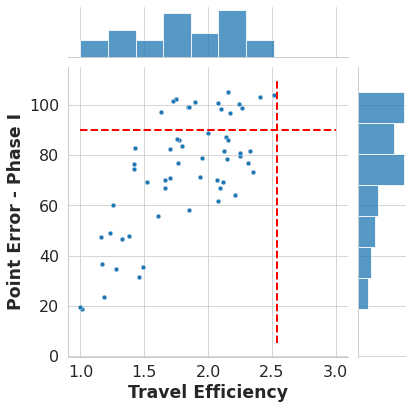

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
g = sns.jointplot(data=sub_performance, y="Point_PreError", x="efficiency")
g.ax_joint.set_ylabel('Point Error - Phase I', fontweight='bold')
g.ax_joint.set_xlabel('Travel Efficiency', fontweight='bold')
g.ax_joint.plot([1,3], [90,90], 'r--', linewidth = 2)
g.ax_joint.plot([2.54,2.54],[5,110] , 'r--', linewidth = 2)
plt.show()

In [ ]:
round(sub_performance[['efficiency','Point_PreError','Point_PostError']].corr(),2)

,efficiency,Point_PreError,Point_PostError
efficiency,1.00,0.66,0.67
Point_PreError,0.66,1.00,0.78
Point_PostError,0.67,0.78,1.00


In [ ]:
pearsonr_ci(sub_performance['efficiency'],sub_performance['Point_PreError'])

(0.7076476285310452,
 7.517122734685798e-10,
 0.5481541647213513,
 0.8174800666427878)

In [ ]:
sub_performance[['efficiency','Point_PreError','Point_PostError']].corr()

,efficiency,Point_PreError,Point_PostError
efficiency,1.000000,0.707648,0.756388
Point_PreError,0.707648,1.000000,0.778302
Point_PostError,0.756388,0.778302,1.000000


In [ ]:
#Travel Efficiency - SplitHalf:0.72
print(round(0.707648/math.sqrt(0.83*0.72),2))
print(round(0.756388/math.sqrt(0.72*0.84),2))
print(round(0.778302/math.sqrt(0.83*0.84),2))

0.92
0.97
0.93


# K-mean Clustering

In [ ]:
sc = StandardScaler()
X = sc.fit_transform(sub_performance[['Point_PreError','Point_PostError','efficiency']])

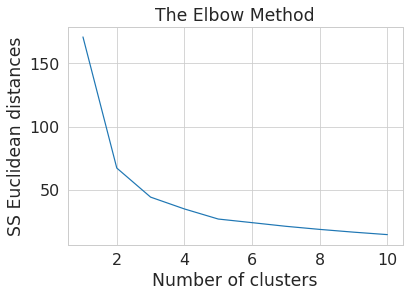

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SS Euclidean distances')
plt.show()

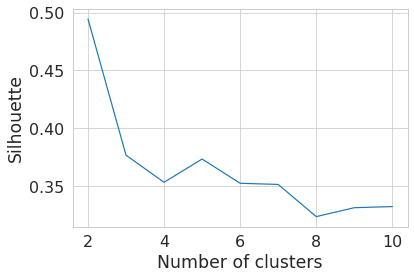

In [ ]:
silhouette_coefficients = []
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
  kmeans.fit(X)
  score = silhouette_score(X,kmeans.labels_)
  silhouette_coefficients.append(score)
plt.plot(range(2, 11), silhouette_coefficients)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
print("low spatial: {}".format(sum(y_kmeans == 1)))
print("high spatial: {}".format(sum(y_kmeans == 0)))

low spatial: 37
high spatial: 20


In [ ]:
sub_performance['low_spatial']=y_kmeans
dVR_l = sub_performance[sub_performance.low_spatial==1]
dVR_h = sub_performance[sub_performance.low_spatial==0]

# High / Low Spatial Groups Performance and Reliability

In [ ]:
pd.set_option('display.max_columns',500)
round(sub_performance.groupby('low_spatial')[['Point_PreError','efficiency','Point_PostError','num_Failures']].describe(),2)

Point_PreError                                                    \
                     count   mean    std    min    25%    50%    75%     max   
low_spatial                                                                    
0                     20.0  50.36  19.62  18.85  35.35  48.37  67.74   83.04   
1                     37.0  86.32  13.01  61.74  77.15  86.15  99.30  105.26   

            efficiency                                           \
                 count  mean   std   min   25%  50%   75%   max   
low_spatial                                                       
0                 20.0  1.38  0.23  1.00  1.22  1.4  1.52  1.85   
1                 37.0  2.04  0.24  1.52  1.84  2.1  2.21  2.51   

            Point_PostError                                                    \
                      count   mean    std    min    25%    50%    75%     max   
low_spatial                                                                     
0                      20.0  40.50  14.41  15.89  29.48  39.17  52.01   69.41   
1                      37.0  78.82  14.60  52.56  64.96  76.93  92.70  104.67   

            num_Failures                                       
                   count  mean   std  min  25%  50%  75%  max  
low_spatial                                                    
0                   20.0  0.10  0.45  0.0  0.0  0.0  0.0  2.0  
1                   37.0  2.03  1.40  0.0  1.0  2.0  3.0  5.0

In [ ]:
stats.ttest_ind(dVR_l.num_Failures, dVR_h.num_Failures)

Ttest_indResult(statistic=5.954910770165943, pvalue=1.902403379753174e-07)

In [ ]:
round(sub_performance.groupby('low_spatial')[['Point_PreError','efficiency','Point_PostError']].agg({skew,kurtosis}),2)

Point_PreError          efficiency          Point_PostError  \
                      skew kurtosis       skew kurtosis            skew   
low_spatial                                                               
0                    -0.05    -1.11       0.20    -0.68            0.22   
1                    -0.13    -1.23      -0.24    -0.75            0.10   

                      
            kurtosis  
low_spatial           
0              -0.87  
1              -1.10

In [ ]:
print("Point Phase I differ from 90")
print(stats.ttest_1samp(dVR_l['Point_PreError'], popmean = 90))
print("Point Phase I CI")
CI_conhen(dVR_l['Point_PreError'],90)
print("Efficiency differ from 2.54")
print(stats.ttest_1samp(dVR_l['efficiency'], popmean = 2.54))
print("Efficiency CI")
CI_conhen(dVR_l['efficiency'], 2.54)

Point Phase I differ from 90
Ttest_1sampResult(statistic=-1.718639213933863, pvalue=0.09427009148105885)
Point Phase I CI
95% Confidence Interval: (81.9846314960579, 90.66201515058874)
cohen_d -0.28
Efficiency differ from 2.54
Ttest_1sampResult(statistic=-12.769556321760959, pvalue=6.212594108965099e-15)
Efficiency CI
95% Confidence Interval: (1.9608439069077104, 2.119596542956505)
cohen_d -2.1


In [ ]:
pp_l = valid_pp1[valid_pp1.Subject.isin(dVR_l.Subject.to_list())]
pp_h = valid_pp1[valid_pp1.Subject.isin(dVR_h.Subject.to_list())]
pp2_l = valid_pp2[valid_pp2.Subject.isin(dVR_l.Subject.to_list())]
pp2_h = valid_pp2[valid_pp2.Subject.isin(dVR_h.Subject.to_list())]
wf_l = valid_wf[valid_wf.Subject.isin(dVR_l.Subject.to_list())]
wf_h = valid_wf[valid_wf.Subject.isin(dVR_h.Subject.to_list())]

In [ ]:
%%R -i pp_l
set.seed(123)
splithalf(data=pp_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 37           0.4   0.09    0.65
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.4, 95% CI [0.09, 0.65]"


In [ ]:
%%R -i pp_h
set.seed(123)
splithalf(data=pp_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 20           0.8   0.64    0.91
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.8, 95% CI [0.64, 0.91]"


In [ ]:
%%R -i wf_l
set.seed(123)
splithalf(data=wf_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "efficiency",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 37          0.01  -0.32    0.38
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.01, 95% CI [-0.32, 0.38]"


In [ ]:
%%R -i wf_h
set.seed(123)
splithalf(data=wf_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "efficiency",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 20          0.66   0.38    0.86
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.66, 95% CI [0.38, 0.86]"


In [ ]:
%%R -i pp2_l
set.seed(123)
splithalf(data=pp2_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 37          0.51   0.27    0.71
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.51, 95% CI [0.27, 0.71]"


In [ ]:
%%R -i pp2_h
set.seed(123)
splithalf(data=pp2_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AngularError",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 20          0.71   0.47    0.87
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.71, 95% CI [0.47, 0.87]"


In [ ]:
round(dVR_l[['efficiency','Point_PreError','Point_PostError']].corr(),2)

,efficiency,Point_PreError,Point_PostError
efficiency,1.00,0.00,0.18
Point_PreError,0.00,1.00,0.23
Point_PostError,0.18,0.23,1.00


In [ ]:
dVR_l[['efficiency','Point_PreError','Point_PostError']].corr()

,efficiency,Point_PreError,Point_PostError
efficiency,1.000000,0.191485,0.178720
Point_PreError,0.191485,1.000000,0.234212
Point_PostError,0.178720,0.234212,1.000000


In [ ]:
#Travel Efficiency - SplitHalf:0.6
print(0.191485/math.sqrt(0.6*0.4))
print(0.178720/math.sqrt(0.6*0.51))
print(0.234212/math.sqrt(0.4*0.51))
print("low Spatial: Efficiency vs. Phase I")
print(pearsonr_ci(dVR_l.efficiency,dVR_l.Point_PreError))

0.390867119497364
0.32308176184458526
0.518554083930292
low Spatial: Efficiency vs. Phase I
(0.19148516754613867, 0.256238858093142, -0.1413008096378926, 0.48538832336261517)


In [ ]:
#Travel Efficiency - SplitHalf:0.01
print(0.003823/math.sqrt(0.01*0.4))
print(0.180860/math.sqrt(0.01*0.51))
print(0.234212/math.sqrt(0.4*0.51))
print("low Spatial: Efficiency vs. Phase I")
print(pearsonr_ci(dVR_l.efficiency,dVR_l.Point_PreError))

0.06044693747411858
2.532546559973058
0.518554083930292
low Spatial: Efficiency vs. Phase I
(0.0038234468583061842, 0.9820818758012709, -0.3205927179744397, 0.32743678776723406)


In [ ]:
bi_pr_test(0.390867119497364,37)

t-statistic = 2.512 pvalue = 0.0168 df = 35
95CI = [0.08, 0.63]


In [ ]:
bi_pr_test(0.0038234468583061842,37)

t-statistic = 0.023 pvalue = 0.9821 df = 35
95CI = [-0.32, 0.33]


In [ ]:
bi_pr_test(0.518554083930292,37)

t-statistic = 3.588 pvalue = 0.0010 df = 35
95CI = [0.23, 0.72]


In [ ]:
dVR_h[['efficiency','Point_PreError','Point_PostError']].corr()

,efficiency,Point_PreError,Point_PostError
efficiency,1.000000,0.638322,0.648893
Point_PreError,0.638322,1.000000,0.781678
Point_PostError,0.648893,0.781678,1.000000


In [ ]:
#Travel Efficiency - SplitHalf:0.65
print(0.635684/math.sqrt(0.8*0.65))
print(0.640541/math.sqrt(0.65*0.71))
print(0.781678/math.sqrt(0.8*0.71))

0.8815350988430963
0.9428901107528808
1.0371790150705984


In [ ]:
pearsonr_ci(dVR_h.efficiency,dVR_h.Point_PreError)

(0.6356839964718027,
 0.002592597172106713,
 0.26876878054263265,
 0.8414906227716388)

In [ ]:
bi_pr_test(0.635684,20)

t-statistic = 3.494 pvalue = 0.0026 df = 18
95CI = [0.27, 0.84]


In [ ]:
dvrl = pearsonr_ci(dVR_l['efficiency'],dVR_l['Point_PreError'])
dvrh = pearsonr_ci(dVR_h['efficiency'],dVR_h['Point_PreError'])

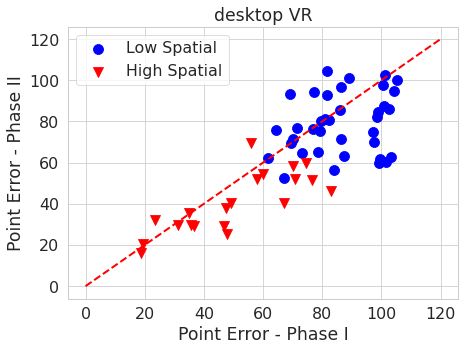

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
fig, ax = plt.subplots(figsize = (7,5))
plt.scatter(dVR_l['Point_PreError'], dVR_l['Point_PostError'], s = 100, c = 'blue', label = 'Low Spatial')
plt.scatter(dVR_h['Point_PreError'], dVR_h['Point_PostError'], s = 100, c = 'red',marker="v", label = 'High Spatial')
# plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 0], s = 300, c = 'yellow', label = 'Centroids')
plt.title('desktop VR')
plt.xlabel('Point Error - Phase I')
plt.ylabel('Point Error - Phase II')
plt.plot([0,120], [0,120], 'r--', linewidth = 2)
plt.legend()
plt.show()

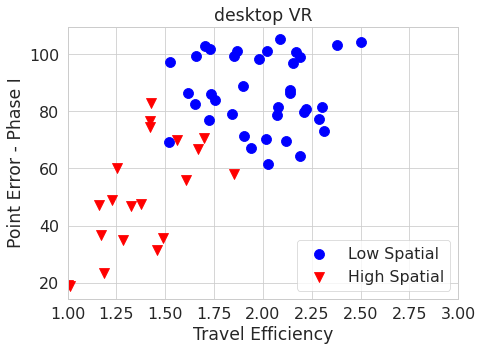

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
fig, ax = plt.subplots(figsize = (7,5))
plt.scatter(dVR_l['efficiency'], dVR_l['Point_PreError'], s = 100, c = 'blue', label = 'Low Spatial')
plt.scatter(dVR_h['efficiency'], dVR_h['Point_PreError'], s = 100, c = 'red',marker="v", label = 'High Spatial')
# plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 0], s = 300, c = 'yellow', label = 'Centroids')
plt.title('desktop VR')
plt.ylabel('Point Error - Phase I')
plt.xlabel('Travel Efficiency')
plt.xlim(1.0,3)
plt.legend()
plt.show()

# Export the data to compare with the immersive Version

In [ ]:
# sub_performance.to_csv('Desktop_Performance.csv',index=False)

# Correlations Comparisons
[resources](https://github.com/psinger/CorrelationStats)

In [ ]:
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh

def rz_ci(r, n, conf_level = 0.95):
    zr_se = pow(1/(n - 3), .5)
    moe = norm.ppf(1 - (1 - conf_level)/float(2)) * zr_se
    zu = atanh(r) + moe
    zl = atanh(r) - moe
    return tanh((zl, zu))

def rho_rxy_rxz(rxy, rxz, ryz):
    num = (ryz-1/2.*rxy*rxz)*(1-pow(rxy,2)-pow(rxz,2)-pow(ryz,2))+pow(ryz,3)
    den = (1 - pow(rxy,2)) * (1 - pow(rxz,2))
    return num/float(den)

def dependent_corr(xy, xz, yz, n, twotailed=True, conf_level=0.95, method='steiger'):
    """
    Calculates the statistic significance between two dependent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between x and z
    @param yz: correlation coefficient between y and z
    @param n: number of elements in x, y and z
    @param twotailed: whether to calculate a one or two tailed test, only works for 'steiger' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'steiger' or 'zou'
    @return: t and p-val
    """
    if method == 'steiger':
        d = xy - xz
        determin = 1 - xy * xy - xz * xz - yz * yz + 2 * xy * xz * yz
        av = (xy + xz)/2
        cube = (1 - yz) * (1 - yz) * (1 - yz)

        t2 = d * np.sqrt((n - 1) * (1 + yz)/(((2 * (n - 1)/(n - 3)) * determin + av * av * cube)))
        p = 1 - t.cdf(abs(t2), n - 3)

        if twotailed:
            p *= 2

        return t2, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(xz, n, conf_level=conf_level)[0]
        U2 = rz_ci(xz, n, conf_level=conf_level)[1]
        rho_r12_r13 = rho_rxy_rxz(xy, xz, yz)
        lower = xy - xz - pow((pow((xy - L1), 2) + pow((U2 - xz), 2) - 2 * rho_r12_r13 * (xy - L1) * (U2 - xz)), 0.5)
        upper = xy - xz + pow((pow((U1 - xy), 2) + pow((xz - L2), 2) - 2 * rho_r12_r13 * (U1 - xy) * (xz - L2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

def independent_corr(xy, ab, n, n2 = None, twotailed=True, conf_level=0.95, method='fisher'):
    """
    Calculates the statistic significance between two independent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between a and b
    @param n: number of elements in xy
    @param n2: number of elements in ab (if distinct from n)
    @param twotailed: whether to calculate a one or two tailed test, only works for 'fisher' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'fisher' or 'zou'
    @return: z and p-val
    """

    if method == 'fisher':
        xy_z = 0.5 * np.log((1 + xy)/(1 - xy))
        ab_z = 0.5 * np.log((1 + ab)/(1 - ab))
        if n2 is None:
            n2 = n

        se_diff_r = np.sqrt(1/(n - 3) + 1/(n2 - 3))
        diff = xy_z - ab_z
        z = abs(diff / se_diff_r)
        p = (1 - norm.cdf(z))
        if twotailed:
            p *= 2

        return z, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(ab, n2, conf_level=conf_level)[0]
        U2 = rz_ci(ab, n2, conf_level=conf_level)[1]
        lower = xy - ab - pow((pow((xy - L1), 2) + pow((U2 - ab), 2)), 0.5)
        upper = xy - ab + pow((pow((U1 - xy), 2) + pow((ab - L2), 2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

# print(dependent_corr(.40, .50, .10, 103, method='steiger'))
print(independent_corr(0.06 , 0.88, 20, 37, method='fisher'))
print(independent_corr(0.19 , 0.99, 24, 24, method='fisher'))

(4.429291068563296, 9.454335375691514e-06)
(7.952890341478841, 1.7763568394002505e-15)


In [ ]:
print(independent_corr(0.06 , 0.88, 20, 37, method='zou'))
print(independent_corr(0.19 , 0.99, 24, 24, method='zou'))

(-1.2765116176132578, -0.3784725706421131)
(-1.2211493126787505, -0.4385994299783849)
